<a href="https://colab.research.google.com/github/AlexNoonan-Syracuse/BigDataProject/blob/main/Macromodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install quandl

In [4]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import grangercausalitytests as grangercausalitytests
import quandl
import requests
from bs4 import BeautifulSoup
import numpy as np



# cpi and gdp
df1 = pd.read_csv("https://raw.githubusercontent.com/AlexNoonan-Syracuse/BigDataProject/main/Macro%20Data.csv")

df1['Date'] = df1['DATE'].apply(lambda x: datetime.datetime.strptime(str(x), "%d/%m/%Y"))
df1.drop(columns=["Unnamed: 7", "% Change (M/M)", "%Change (Q/Q)", "% Change (Y/Y)", "% Change Q/Q", "DATE"], inplace =True )

df1['cpiAnnualizedPct'] = ((df1['CPIAUCSL']/df1['CPIAUCSL'].shift(1))**12-1)*100 
df1['gdpAnnualizedPct'] = ((df1['Nominal GDP']/df1['Nominal GDP'].shift(1))**12-1)*100 


df1 = df1.set_index(['Date'])
# pmi data
quandl.ApiConfig.api_key = "FxsNx9PisEsskkErUy4k"
df2 = quandl.get("ISM/MAN_PMI")


# treasury data
# gathering the web page and creating a dataframe of the treasury history

url = 'https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yieldAll'

r = requests.get(url)
html = r.text
soup = BeautifulSoup(html)
table = soup.find('table', {"class": "t-chart"})
rows = table.find_all('tr')
data = []
for row in rows[1:]:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    data.append([ele for ele in cols if ele])

df3 = pd.DataFrame(data, columns=['Date', 'One_Mo', 'Two_Mo', 'Three_Mo', 'Six_Mo', 'One_Yr', 'Two_Yr', 'Three_Yr', 'Five_Yr', 'Seven_Yr', 'Ten_Yr', 'Twenty_Yr', 'Thirty_Yr'])

df3.replace(to_replace='N/A', value=0, inplace=True)
df3 = df3.astype({'One_Mo':'float64', 'Two_Mo':'float64', 'Three_Mo':'float64', 'Six_Mo':'float64', 'One_Yr':'float64', 'Two_Yr':'float64', 'Three_Yr':'float64', 'Five_Yr':'float64', 'Seven_Yr':'float64', 'Ten_Yr':'float64', 'Twenty_Yr':'float64', 'Thirty_Yr':'float64'})
df3['Date'] = pd.to_datetime(df3['Date'], format="%m/%d/%y")

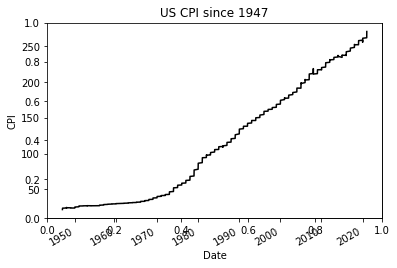

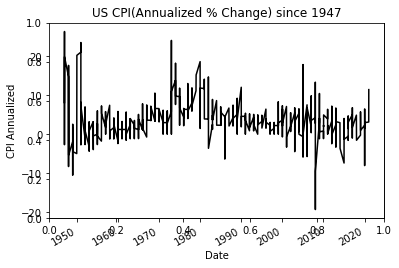

In [5]:

# plot cpi and annualized rate much more stablizied on the second one

fig, axis = plt.subplots()
axis = fig.add_subplot(1,1,1)
axis.set_xlabel("Date")
axis.set_ylabel("CPI")
axis.set_title("US CPI since 1947")

df1['CPIAUCSL'].plot(ax= axis, style='k-')

fig, axis = plt.subplots()
axis = fig.add_subplot(1,1,1)
axis.set_xlabel("Date")
axis.set_ylabel("CPI Annualized")
axis.set_title("US CPI(Annualized % Change) since 1947")


df1['cpiAnnualizedPct'].plot(ax= axis, style='k-')
plt.show()

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
# indexed date
cpiModelDf = df1.dropna()
cpiModelDf.head()

# ARIMA Model

for pindex in range(3):
    for qindex in range(3):
      p = pindex + 1 
      q = qindex + 1
      CPI_arima_model = ARIMA(cpiModelDf['cpiAnnualizedPct'], order = (p,1,q)).fit()
      print('AR:', p , 'MA:', q, 'AIC:', CPI_arima_model.aic)

CPI_arima_model_selected = ARIMA(cpiModelDf['cpiAnnualizedPct'], order = (2,1,2)).fit()
# fitted model parameters
print("Fitted model")
print(CPI_arima_model_selected.params)
print(CPI_arima_model_selected.summary())

AR: 1 MA: 1 AIC: 4721.640584587954
AR: 1 MA: 2 AIC: 4722.64868430844
AR: 1 MA: 3 AIC: 4723.701490075733
AR: 2 MA: 1 AIC: 4722.694419865345
AR: 2 MA: 2 AIC: 4721.359985096982
AR: 2 MA: 3 AIC: 4723.297890603646
AR: 3 MA: 1 AIC: 4724.657685184024
AR: 3 MA: 2 AIC: 4718.696064215924
AR: 3 MA: 3 AIC: 4719.121945970353
Fitted model
const                      -0.002871
ar.L1.D.cpiAnnualizedPct   -0.618466
ar.L2.D.cpiAnnualizedPct    0.264439
ma.L1.D.cpiAnnualizedPct    0.056919
ma.L2.D.cpiAnnualizedPct   -0.830922
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:     D.cpiAnnualizedPct   No. Observations:                  892
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2354.680
Method:                       css-mle   S.D. of innovations              3.388
Date:                Thu, 05 Aug 2021   AIC                           4721.360
Time:                        00:00:58   BIC                           4750.121

In [ ]:
# model prediction
	
start_index = '1990-12-25'
end_index = '1990-12-25'
forecast = model_fit.predict(start=start_index, end=end_index)